## This notebook generates figures 

<IPython.core.display.Javascript object>


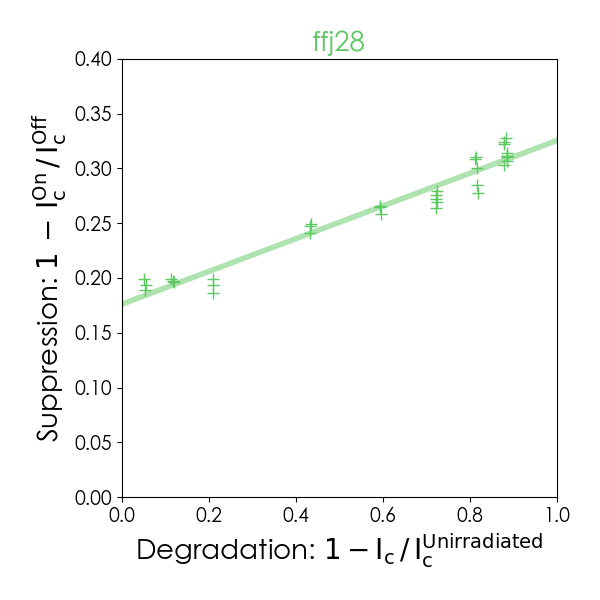

In [23]:
tapeid, names = 'f28', ['tapeid', 'power', 'degradation', 'suppression']
df = pd.read_excel(dfs.master, sheet_name='data', usecols=[0, 13, 53, 55], names=names, skiprows=1)
data = df[(df.tapeid == tapeid) & (34 <= df.power) & (df.power <= 38)]

fig, ax = plt.subplots()

x, y = 1-data.degradation, data.suppression
popt, pcov = curve_fit(ff.linear, x, y)
xsmooth = np.linspace(0, 1, 1000)
ysmooth = ff.linear(xsmooth, *popt)

ax.plot(xsmooth, ysmooth, linewidth=4, alpha=.5, color=dfs.colors_tapes[tapeid])
ax.plot(x, y, marker='+', linestyle='None', color=dfs.colors_tapes[tapeid], alpha=1)

ax.set_xlim(0, 1.)
ax.set_ylim(0, .4)
ax.set_title(tapeid.replace('f', 'ffj'), color=dfs.colors_tapes[tapeid])
ax.set_xlabel('Degradation: $\mathrm{1 - I_c\, /\, I_c^{Unirradiated}}$')
ax.set_ylabel('Suppression: $\mathrm{1\, -\, I_c^{On}\, /\, I_c^{Off}}$')
fig.tight_layout()

# Interpolation of REBCO layer temperature from Critical Current measured during irradiation

Here we plot all the critical temperature vs temperature calibrations used to estimate the temperature of REBCO during irradiation. On each plot, we overlay the "beam off IV" for each of the "beam on events" where we use the calibration as evidence that the calibration has not changed.

In [37]:
%pylab notebook

import warnings
warnings.filterwarnings("ignore")

import sys, os
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_figure_style as dfs
for lib in [hts, ff, misc, dfs]:
    importlib.reload(lib)

    

cols = [0, 1, 12, 13, 14, 19, 23, 25, 27, 29, 41, 52, 53, 54, 55, 56, 57, 58, 59]
names = [
    'tapeid', 
    'anneal',
    'energy', 
    'power', 
    'powerError',
    'ic0',
    'icoff',
    'noff',
    'icon',
    'non',
    'tTAR_OFF',
    'tREBCO',
    'degradation',
    'degradationError',
    'suppression', 
    'suppressionError',
    'suppression_corrected',
    'suppressionError_corrected',
    'outlier' 
]
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)

#################################
########## Filter data ##########
#################################
cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1

data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

df.columns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 676

Datapoints for f33 68

Datapoints for f20 14

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 58

Datapoints for f37 223


Index(['tapeid', 'anneal', 'energy', 'power', 'powerError', 'ic0', 'icoff',
       'noff', 'icon', 'non', 'tTAR_OFF', 'tREBCO', 'degradation',
       'degradationError', 'suppression', 'suppressionError',
       'suppression_corrected', 'suppressionError_corrected', 'outlier'],
      dtype='object')

## We find an empirical relation between Ic and Tc degradation

It holds suprisingly well for all samples, except ffj20!

<IPython.core.display.Javascript object>


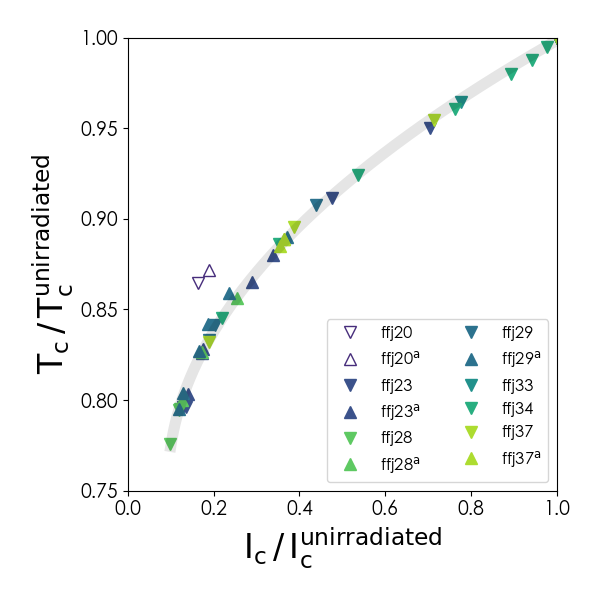

[ 0.69975365  0.75392883  0.13455914 -0.01259732]


In [40]:
fig, ax = plt.subplots()
percent = 1

ax.set_xlabel('$\mathrm{I_c \, / \, I_c^{unirradiated}}$', fontsize=24)
ax.set_ylabel('$\mathrm{T_c \, / \, T_c^{unirradiated}}$', fontsize=24)
ax.set_xlim(0, percent*1.0)
ax.set_ylim(0.75, percent*1.)

df = pd.read_excel(dfs.master, sheet_name='TcIc', usecols=[0, 1, 4, 6], names=['tapeid', 'anneal', 'tc', 'ic'], skiprows=1)

icnorm = []
tcnorm = []

for tapeid in [t for t in np.sort(df.tapeid.unique())]:
    data = df[df.tapeid == tapeid]
    x, y = data.ic/data.ic.max(), data.tc/data.tc.max()
    
    if tapeid != 'f20':
        for d in x.values:
            icnorm.append(d)
        for d in y.values:
            tcnorm.append(d)
        mec = mfc = dfs.colors_tapes[tapeid]
    else:
        mec, mfc = dfs.colors_tapes[tapeid], 'None'
        
    ax.plot(percent*x[data.anneal == 1], percent*y[data.anneal == 1], marker='v', markersize=8, linestyle='None', mfc=mfc, mec=mec, label=tapeid.replace('f', 'ffj'))
    if len(y[data.anneal > 1]) > 0:
        ax.plot(percent*x[data.anneal > 1], percent*y[data.anneal > 1], marker='^', markersize=8, linestyle='None', mfc=mfc, mec=mec, label=tapeid.replace('f', 'ffj')+'$\mathrm{^a}$')

fitfunction = ff.sqrt

popt, pcov = curve_fit(fitfunction, np.array(icnorm), np.array(tcnorm))
xsmooth = np.linspace(0.1, 1, 10000)
xsmooth = xsmooth[popt[2]*xsmooth >= np.abs(popt[3])]
ysmooth = fitfunction(xsmooth, *popt)
print(popt)

ax.plot((xsmooth)*percent, (ysmooth)*percent, linewidth=8, alpha=.1, color='k')
ax.legend(loc='lower right', ncols=2)
fig.tight_layout()

ax.set_rasterized(True)
plt.savefig(dfs.outputDirectory+'degradation-b.svg')

<IPython.core.display.Javascript object>


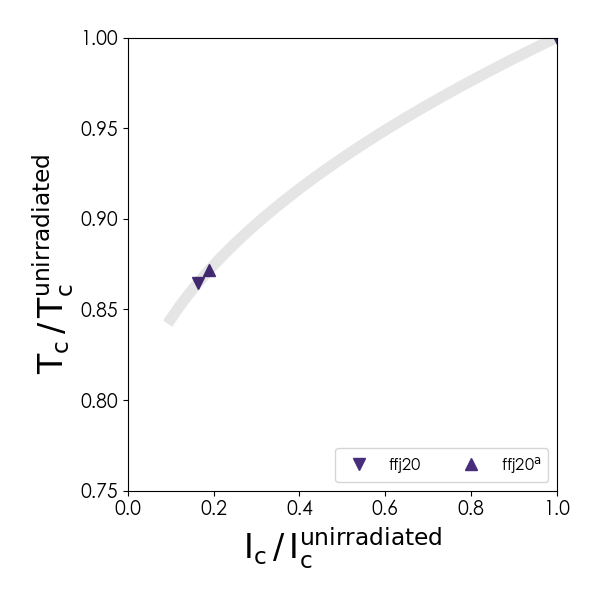

[0.35584097 0.77284068 0.40751745]


In [45]:
fig, ax = plt.subplots()
percent = 1

ax.set_xlabel('$\mathrm{I_c \, / \, I_c^{unirradiated}}$', fontsize=24)
ax.set_ylabel('$\mathrm{T_c \, / \, T_c^{unirradiated}}$', fontsize=24)
ax.set_xlim(0, percent*1.0)
ax.set_ylim(0.75, percent*1.)

df = pd.read_excel(dfs.master, sheet_name='TcIc', usecols=[0, 1, 4, 6], names=['tapeid', 'anneal', 'tc', 'ic'], skiprows=1)

icnorm = []
tcnorm = []

for tapeid in [t for t in np.sort(df.tapeid.unique()) if t == 'f20']:
    data = df[df.tapeid == tapeid]
    x, y = data.ic/data.ic.max(), data.tc/data.tc.max()
    
    for d in x.values:
        icnorm.append(d)
    for d in y.values:
        tcnorm.append(d)
    mec = mfc = dfs.colors_tapes[tapeid]
        
    ax.plot(percent*x[data.anneal == 1], percent*y[data.anneal == 1], marker='v', markersize=8, linestyle='None', mfc=mfc, mec=mec, label=tapeid.replace('f', 'ffj'))
    if len(y[data.anneal > 1]) > 0:
        ax.plot(percent*x[data.anneal > 1], percent*y[data.anneal > 1], marker='^', markersize=8, linestyle='None', mfc=mfc, mec=mec, label=tapeid.replace('f', 'ffj')+'$\mathrm{^a}$')

fitfunction = lambda x, a, b, c: ff.sqrt(x, a, b, c, 0)

popt, pcov = curve_fit(fitfunction, np.array(icnorm), np.array(tcnorm))
xsmooth = np.linspace(0.1, 1, 10000)
#xsmooth = xsmooth[popt[2]*xsmooth >= np.abs(popt[3])]
ysmooth = fitfunction(xsmooth, *popt)
print(popt)

ax.plot((xsmooth)*percent, (ysmooth)*percent, linewidth=8, alpha=.1, color='k')
ax.legend(loc='lower right', ncols=2)
fig.tight_layout()

## We show that Ic(T) is a monotonic function of degradation

<IPython.core.display.Javascript object>


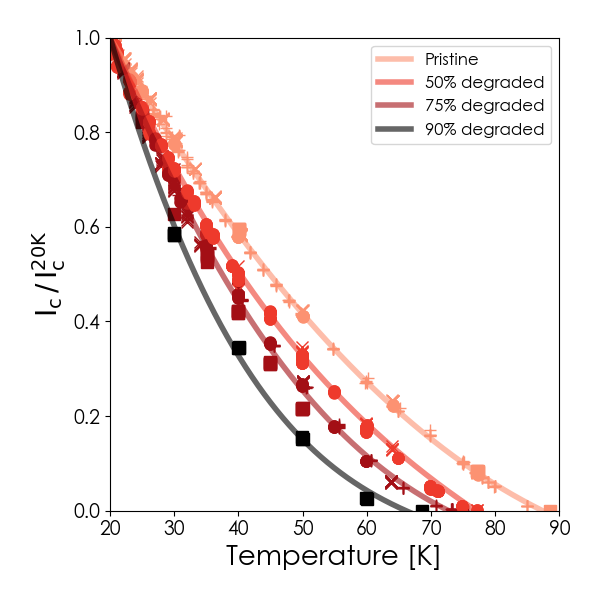

0.09249471677635596


In [11]:
fig, ax = plt.subplots()
fitfunction = ff.cubic2
path_top = '../data/IcT/IcT/'

pristineTemperature = np.array([])
damagedTemperature =  np.array([])
pristineIc = np.array([])
damagedIc = np.array([])
temperature50 = np.array([])
ic50 = np.array([])
temperature25 = np.array([])
ic25 = np.array([])

degradation = []
palette = sns.color_palette('Reds', 7)

for tape, m in zip(['f20', 'f28', 'f29', 'f37'], ['+', 's', 'x', 'o']):
    path_tape = path_top+'{}/'.format(tape)
    
    for icT in np.sort([f for f in os.listdir(path_tape) if f != '.DS_Store']):
        if '77' not in icT:
            path = path_tape+'{}/'.format(icT)
            fpaths = [path+f for f in os.listdir(path) if f[:2] == 'Ic']
            _, _, ictdata, _ = hts.getIcT(fpaths, vb=False)
            ics, temperatures = ictdata.ic.values.tolist(), ictdata.temperature.values.tolist()
            
            ic20k = np.max(ics)
            if icT == '0e20pm2':
                ic020k = ic20k
                ics.append(0.001)
                temperatures.append(88.5)
                
            if icT == 'afterBeamOn':
                ics.append(0.001)
                temperatures.append(68.62868916)
                print(ic20k/ic020k)
                
            x, y = np.array(temperatures), np.array(ics)/ic20k
            
            if (.5 < ic20k/ic020k) & (ic20k/ic020k <= 1):
                c = palette[2]
                pristineTemperature = np.append(pristineTemperature, temperatures)
                pristineIc = np.append(pristineIc, np.array(ics)/ic20k)
                
            elif (.25 < ic20k/ic020k) & (ic20k/ic020k <= .5):
                c = palette[4]
                if tape != 'f37':
                    temperature50 = np.append(temperature50, temperatures)
                    ic50 = np.append(ic50, np.array(ics)/ic20k)
                
            elif (.1 < ic20k/ic020k) & (ic20k/ic020k <= .25):
                c = palette[6]
                temperature25 = np.append(temperature25, temperatures)
                ic25 = np.append(ic25, np.array(ics)/ic20k)

            else:
                c = 'k'
                damagedTemperature = np.append(damagedTemperature, temperatures)
                damagedIc = np.append(damagedIc, np.array(ics)/ic20k)
                     
            ax.plot(x, y, linestyle='None', marker=m, markersize=8, mec=c, mfc=c)#'white')

ax.set_ylim(0, 1)
ax.set_xlim(20, 90)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('$\mathrm{I_c \, / \, I_c^{20K}}$')
fig.tight_layout()


# Plot the pristine and heavily degraded datasets, and fit to a third-order polynomial

temperatures = [pristineTemperature, temperature50, temperature25, damagedTemperature]
ics = [pristineIc, ic50, ic25, damagedIc]
colors = [palette[2], palette[4], palette[6], 'k']
for x, y, c, l in zip(temperatures, ics, colors, ['Pristine', '50% degraded', '75% degraded', '90% degraded']):
    xsmooth = np.linspace(0, np.max(x), 10000)
    popt, pcov = curve_fit(fitfunction, x, y)
    ax.plot(xsmooth, fitfunction(xsmooth, *popt), linestyle='-', linewidth=4, alpha=0.6, color=c, label=l)
ax.legend()

plt.savefig(dfs.outputDirectory+'degradation-a.svg')

## For all tapes we take the two extremes

<IPython.core.display.Javascript object>


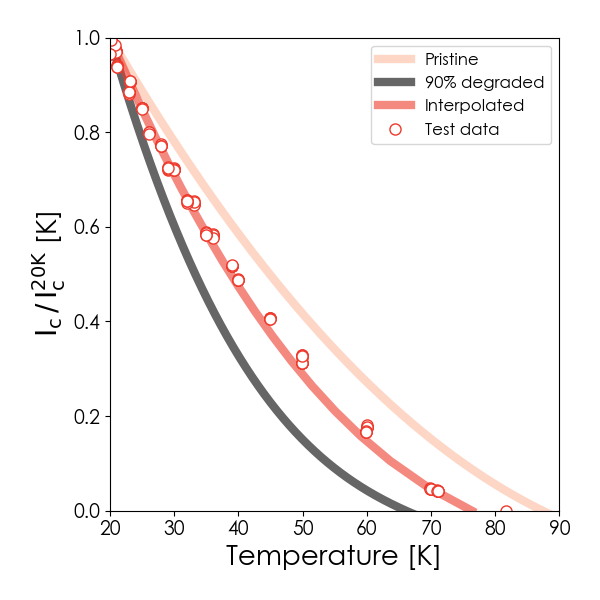

Pristine
Optimized parameters for Pristine [-6.25265623e-08  1.29529294e-04 -2.32821930e-02]


90% degraded
Optimized parameters for 90% degraded [-4.50561071e-06  7.54452215e-04 -4.68947575e-02]




In [12]:
fig, ax = plt.subplots()
fitfunction = ff.cubic2
xsmooth = np.linspace(20, 90, 10000)


# Plot the pristine and heavily degraded datasets, and fit to a third-order polynomial
for l, x, y, c, l in zip(['pristine', 'degraded'], [pristineTemperature, damagedTemperature], [pristineIc, damagedIc], [palette[1], 'k'], ['Pristine', '90% degraded']):
    popt, pcov = curve_fit(fitfunction, x, y)
    ax.plot(xsmooth, fitfunction(xsmooth, *popt), linestyle='-', linewidth=6, alpha=0.6, color=c, label=l)
    #ax.plot(x, y, linestyle='None', marker='o', color=c)
    print(l)
    print('Optimized parameters for', l, popt)
    print('\n')
 
# Using the polynomials: try to predict another curve
tape, ic0, interpolation = 'f37', 34.88, '150keV'
path = '../data/IcT/IcT/{}/{}/'.format(tape, interpolation)
_, _, ictdata, _ = hts.getIcT([path+f for f in os.listdir(path) if (f != '.DS_Store')], vb=False)
ic, t = ictdata.ic.values.tolist(), ictdata.temperature.values.tolist()
icoff = np.max(ic)
yprediction = np.linspace(0, 1, 20)
suppression, icon, xprediction = hts.v_getCorrectedSuppression(yprediction*icoff, icoff, ic0)
ax.plot(xprediction, yprediction, color=palette[4], linestyle='-', linewidth=6, alpha=.6, label='Interpolated')
ax.plot(t, ic/icoff, marker='o', mec=palette[4], mfc='white', linestyle='None', label='Test data')

ax.set_ylim(0, 1)
ax.set_xlim(20, 90)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('$\mathrm{I_c\, /\, I_c^{20K}}$ [K]')
ax.legend()
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'degradation-c.svg')

## Test the method with ffj37 data

Here we show that our method effectively eliminates the difference between earlier power scans (less degradation) and later ones (more degradation).

<IPython.core.display.Javascript object>


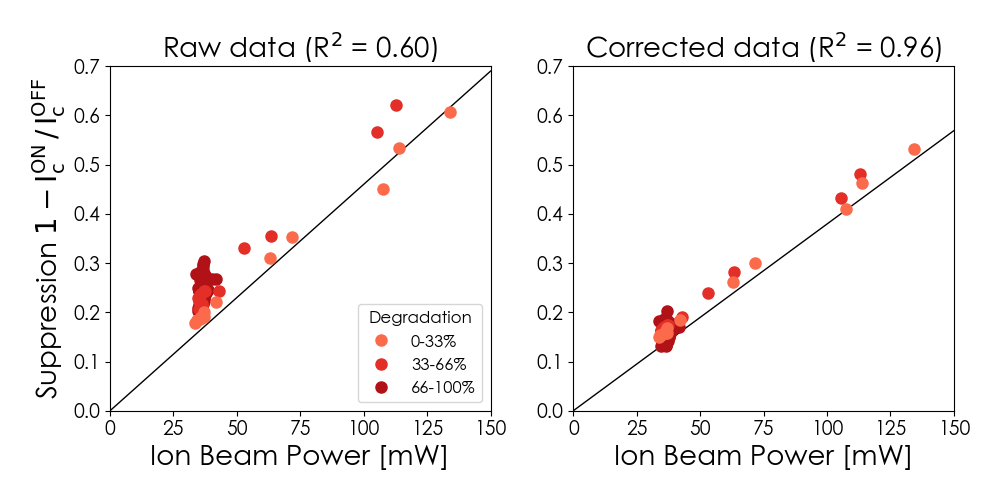

In [33]:
def getR2(x, y):
    popt, pcov = curve_fit(ff.affine, x, y)
    yfit = ff.affine(x, *popt)
    residuals = y - yfit
    ss_res, ss_tot = np.sum(residuals**2), np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot), popt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

tapeid = 'f37'
  
x, ex = data.power, data.powerError
y, ey = data.suppression_corrected, data.suppressionError
z, ez = data.suppression, data.suppressionError

axes[0].set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
cut = (data.tapeid == tapeid) & (data.anneal == 1)
for ax, t, d in zip(axes, ['Raw data', 'Corrected data'], [z, y]):
    ax.set_ylim(0, .7)
    ax.set_xlim(0, 150)
    rsq, popt = getR2(x[cut], d[cut])
    xsmooth = np.linspace(0, 150, 1000)
    ysmooth = ff.affine(xsmooth, *popt)
    ax.plot(xsmooth, ysmooth, linewidth=1, color='k')
    ax.set_title(t+' (R$^2$ = '+'{:4.2f})'.format(rsq))
    ax.set_xlabel('Ion Beam Power [mW]')
    
nsegments = 5
pintervals = np.linspace(0, 1, nsegments)
palette = sns.color_palette('Reds_r', len(pintervals))
labels = ['66-100%', '33-66%', '0-33%']
for p, c, l in zip(pintervals, palette, labels):

    cut = (p <= data.degradation) & (data.degradation <= p+1/nsegments) & (data.tapeid == tapeid) & (data.anneal == 1)

    if x[cut].count() > 0:
        axes[0].plot(x[cut], z[cut], marker='o', linestyle='None', color=c, markersize=8, alpha=1, label=l)
        axes[1].plot(x[cut], y[cut], marker='o', linestyle='None', color=c, markersize=8, alpha=1)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], loc='lower right', title='Degradation')
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'figure11-correction-example.svg')    